In [1]:
from PLBenchmarks import targets, ligands, edges
from IPython.core.display import HTML
import pint
import os
from freeenergyframework import plotting, stats, wrangle, absolute, plotlying
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
ureg = pint.UnitRegistry()
import plotly.graph_objects as go
import pandas as pd

RDKit WARNING: [16:29:37] Enabling RDKit 2019.09.3 jupyter extensions


Function to read in data

In [2]:
def getResults(target, forcefield='openff-1.0.0.offxml'):
    # read in result file
    res = pd.read_csv(f'../results/{target}_{forcefield}.csv', header=[0,1,2], comment='#', skipinitialspace=True, sep=',')
    res.index = res.iloc[:,0].values
    
    # read in exp. data
    edg = edges.edgeSet(target)
    df = edg.getDF(columns=[0,1, 'exp. DeltaG [kcal/mol]', 'exp. Error [kcal/mol]'])
    df.index = pd.Series(['edge_' + str(lig1) + '_' + str(lig2) for lig1, lig2 in zip(df[0].values, df[1].values)])
   
 
    # remove unit of calculated values
    res['exp_DDG'] = df['exp. DeltaG [kcal/mol]'].apply(lambda x: x.magnitude)
    res['dexp_DDG'] = df['exp. Error [kcal/mol]'].apply(lambda x: x.magnitude)

    return res
df = getResults('pde2')
#print(df.columns)

# Read in data for Parsley forcefield

In [3]:
forcefield = 'openff-1.0.0.offxml'
dfs = []
for target in targets.target_list:
    target = target["name"]
    if not os.path.exists(f'../results/{target}_{forcefield}.csv'):
        continue
    print(target)
    df = getResults(target, forcefield=forcefield)
    df.index = pd.Series([f'{target}_{edge}' for edge in df.index.values])
    dfs.append( df )
all_edges = pd.concat(dfs)
all_edges.columns.values

jnk1
pde2
thrombin
p38
ptp1b
galectin
cdk2
cmet
mcl1
bace_hunt


array([('leg', 'repeat', 'Unnamed: 0_level_2'), ('water', '1', 'val'),
       ('water', '1', 'err'), ('water', '1', 'aerr'),
       ('water', '1', 'conv'), ('water', '2', 'val'),
       ('water', '2', 'err'), ('water', '2', 'aerr'),
       ('water', '2', 'conv'), ('water', '3', 'val'),
       ('water', '3', 'err'), ('water', '3', 'aerr'),
       ('water', '3', 'conv'), ('protein', '1', 'val'),
       ('protein', '1', 'err'), ('protein', '1', 'aerr'),
       ('protein', '1', 'conv'), ('protein', '2', 'val'),
       ('protein', '2', 'err'), ('protein', '2', 'aerr'),
       ('protein', '2', 'conv'), ('protein', '3', 'val'),
       ('protein', '3', 'err'), ('protein', '3', 'aerr'),
       ('protein', '3', 'conv'), ('ddg', '1', 'val'), ('ddg', '1', 'err'),
       ('ddg', '1', 'aerr'), ('ddg', '2', 'val'), ('ddg', '2', 'err'),
       ('ddg', '2', 'aerr'), ('ddg', '3', 'val'), ('ddg', '3', 'err'),
       ('ddg', '3', 'aerr'), ('ddg_mean', '-', 'val'),
       ('ddg_mean', '-', 'err'), ('ddg_me

# Calculate MUEs over three repeats

In [4]:
# MUE of repeats
mues = dict()
for wp in ['water', 'protein', 'ddg']:
    df2 = all_edges.loc[:,np.in1d(all_edges.columns.get_level_values(0), [wp])]
    df2 = df2.loc[:,np.in1d(df2.columns.get_level_values(2), ['val'])]
    mues[wp] = df2.subtract(df2.mean(axis=1), axis=0).abs().sum(axis=1)
mues = pd.DataFrame(mues)

mues.columns

Index(['water', 'protein', 'ddg'], dtype='object')

# Extract convergence and analytical errors

In [5]:
convs = all_edges.loc[:,np.in1d(all_edges.columns.get_level_values(2), ['conv'])]
convs

water             protein            
                              1     2     3       1     2     3
                           conv  conv  conv    conv  conv  conv
jnk1_edge_17124-1_18634-1  0.05  0.12 -0.03    0.12 -0.10  0.05
jnk1_edge_18626-1_18624-1  0.12  0.02  0.04   -0.15 -0.10 -0.23
jnk1_edge_18636-1_18625-1 -0.02  0.07  0.06    0.13  0.21  0.27
jnk1_edge_18632-1_18624-1 -0.01  0.16  0.05    0.12  0.03  0.04
jnk1_edge_18635-1_18625-1  0.20  0.12  0.21   -0.03 -0.09 -0.16
...                         ...   ...   ...     ...   ...   ...
bace_hunt_edge_19_15      -0.03  0.30  0.21    0.35 -0.09 -0.13
bace_hunt_edge_18_19       0.04 -0.03 -0.02    0.21 -0.03  0.35
bace_hunt_edge_16_15      -0.11 -0.10  0.56    0.27  0.17  0.18
bace_hunt_edge_41_29       0.78 -0.04  0.99    1.00  1.00  1.00
bace_hunt_edge_18_39      -0.03 -0.04 -0.02    0.07  0.07  0.07

[374 rows x 6 columns]

In [6]:
aerr = all_edges.loc[:,np.all([np.in1d(all_edges.columns.get_level_values(2), ['aerr']),
                                np.in1d(all_edges.columns.get_level_values(1), ['1','2','3'])], axis=0)]
aerr

water             protein                     \
                              1     2     3       1        2         3   
                           aerr  aerr  aerr    aerr     aerr      aerr   
jnk1_edge_17124-1_18634-1  0.11  0.10  0.09    0.09     0.09      0.09   
jnk1_edge_18626-1_18624-1  0.09  0.09  0.09    0.11     0.11      0.10   
jnk1_edge_18636-1_18625-1  0.08  0.08  0.08    0.15     0.16      0.18   
jnk1_edge_18632-1_18624-1  0.08  0.07  0.07    0.09     0.07      0.08   
jnk1_edge_18635-1_18625-1  0.05  0.05  0.05    0.08     0.07      0.07   
...                         ...   ...   ...     ...      ...       ...   
bace_hunt_edge_19_15       0.06  0.15  0.17    0.16     0.20      0.12   
bace_hunt_edge_18_19       0.04  0.05  0.04    0.08     0.06      0.09   
bace_hunt_edge_16_15       0.07  0.07  0.18    0.35     0.19      0.38   
bace_hunt_edge_41_29       1.01  0.62  3.44  606.64  1126.22  12991.20   
bace_hunt_edge_18_39       0.07  0.06  0.06    0.18     0.14      0.17   

                              ddg                     
                                1        2         3  
                             aerr     aerr      aerr  
jnk1_edge_17124-1_18634-1    0.14     0.13      0.13  
jnk1_edge_18626-1_18624-1    0.14     0.14      0.13  
jnk1_edge_18636-1_18625-1    0.17     0.18      0.20  
jnk1_edge_18632-1_18624-1    0.12     0.10      0.11  
jnk1_edge_18635-1_18625-1    0.09     0.09      0.09  
...                           ...      ...       ...  
bace_hunt_edge_19_15         0.17     0.25      0.21  
bace_hunt_edge_18_19         0.09     0.08      0.10  
bace_hunt_edge_16_15         0.36     0.20      0.42  
bace_hunt_edge_41_29       606.64  1126.22  12991.20  
bace_hunt_edge_18_39         0.19     0.15      0.18  

[374 rows x 9 columns]

# Plot analytical error vs. convergence

In [7]:
import itertools

fig = go.Figure()

# Add traces
for wp, rep in itertools.product(['water', 'protein'], ['1', '2', '3']):
    fig.add_trace(go.Scatter(x=convs.loc[:,(wp, rep)].values.flatten(), y=aerr.loc[:,(wp, rep)].values.flatten(),
                    mode='markers',
                    hovertext=convs.index,
                    name=f'{wp}{rep}'))
fig.update_layout(xaxis=dict(title='Convergence'), yaxis=dict(range=[0,5], title='Analytical Error [kcal mol<sup>-1</sup>]'))
fig.show()

/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning:

indexing past lexsort depth may impact performance.



The analytical error and the convergence value are redundant metrics. In the following, a simulation is considered as not converged with a convergence > 0.8.

# Calculate the number of not converged simulations in water and protein

In [8]:
bConv_water = (convs.loc[:,'water'] < 0.8).values
bConv_protein = (convs.loc[:,'protein'] < 0.8).values
print(f'Not converged simulations in water: {np.prod(bConv_water.shape)-np.sum(bConv_water)}\n\
and in protein: {np.prod(bConv_protein.shape)-np.sum(bConv_protein)}\n\
out of {np.prod(bConv_protein.shape)} simulations each.')

Not converged simulations in water: 16
and in protein: 101
out of 1122 simulations each.


# Calculate the number of not converged edges (= set of 3 simulations) in water and protein or the DDG (= set of 6 simulations)

In [9]:
bConv_water = (convs.loc[:,'water'].max(axis=1) < 0.8).values
bConv_protein = (convs.loc[:,'protein'].max(axis=1) < 0.8).values
bConv = (convs.max(axis=1) < 0.8).values
print(f'Not converged edges in water: {np.prod(bConv_water.shape)-np.sum(bConv_water)}\n\
and in protein: {np.prod(bConv_protein.shape)-np.sum(bConv_protein)}\n\
out of {np.prod(bConv_protein.shape)} edges each.\n\
This results in {np.prod(bConv.shape)-np.sum(bConv)} not converged out of {np.prod(bConv.shape)} DDG values.')

Not converged edges in water: 8
and in protein: 57
out of 374 edges each.
This results in 57 not converged out of 374 DDG values.


# Plot the distributions of MUE's of DG values over repeats in water and protein simulations and MUE's of the resulting DDG values.

In [10]:
fig = go.Figure()
fig.add_trace(go.Violin(y=mues['water'], hovertext=mues.index, name='water'))
fig.add_trace(go.Violin(y=mues['water'][bConv_water], hovertext=mues.index[bConv_water], name='water_filtered'))
fig.add_trace(go.Violin(y=mues['protein'], hovertext=mues.index, name='protein'))
fig.add_trace(go.Violin(y=mues['protein'][bConv_protein], hovertext=mues.index[bConv_protein], name='protein_filtered'))
fig.add_trace(go.Violin(y=mues['ddg'], hovertext=mues.index, name='DDG'))
fig.add_trace(go.Violin(y=mues['ddg'][bConv], hovertext=mues.index[bConv], name='DDG_filtered'))
fig.update_layout(
    title='MUE of DG over 3 repeats of simulations in water, protein and the DDG difference<br>filtered set excludes simulations with convergence > 0.8',
    yaxis=dict(range=[0,10], title='MUE(repeats) [kcal mol<sup>-1</sup>]'))

In [11]:
notbConv = np.invert(bConv)
notConvEdges = mues.index[notbConv].values
dfs = []
for e in notConvEdges:
    e = e.split('_edge_')
    target = e[0]
    edge = 'edge_' + '_'.join(e[1:])
    eSet = edges.edgeSet(target)
    df = eSet[edge].getDF()
    df['target'] = target
    dfs.append(df)
notConvEdges = pd.concat(dfs, axis=1).T


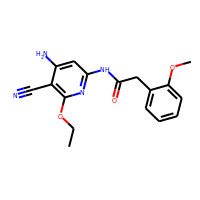
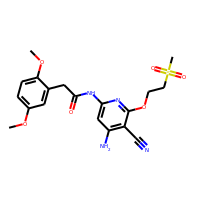
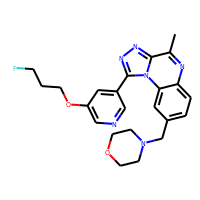
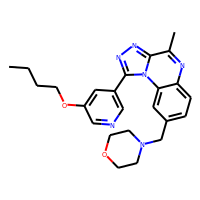
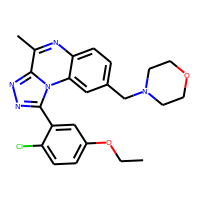
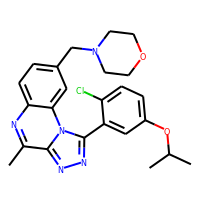
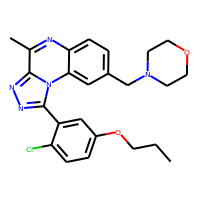
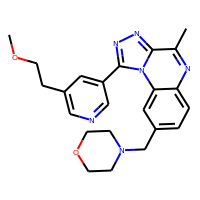
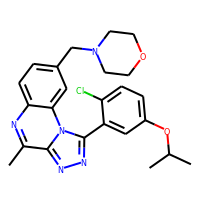
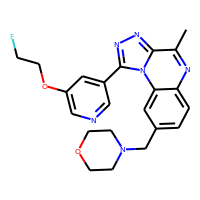
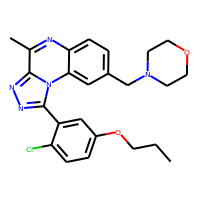
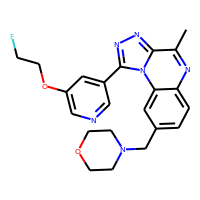
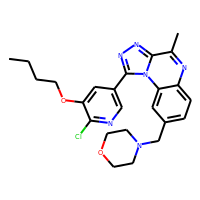
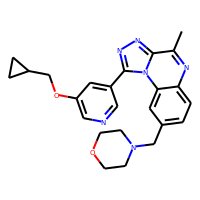
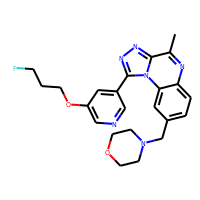
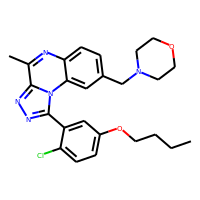
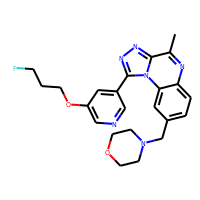
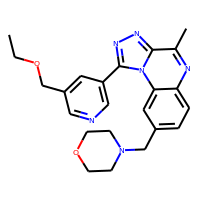
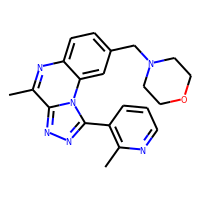
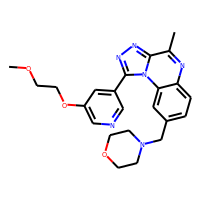
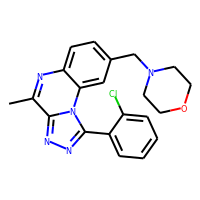
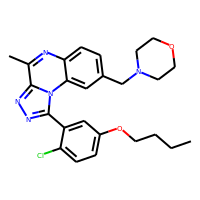
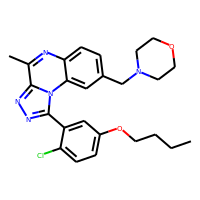
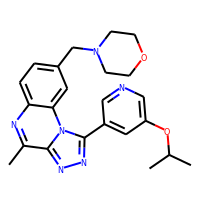
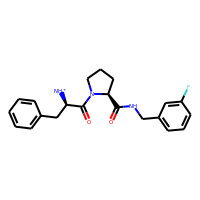
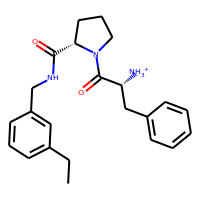
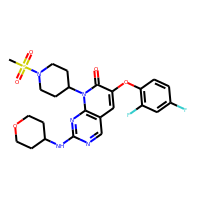
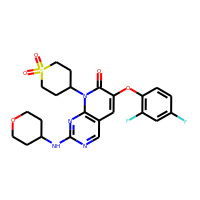
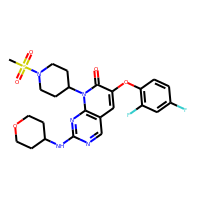
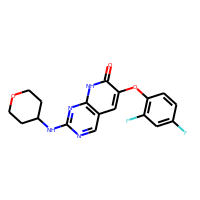
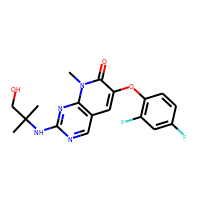
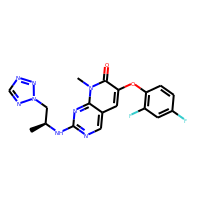
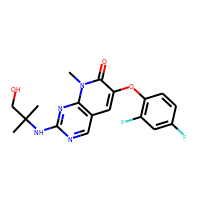
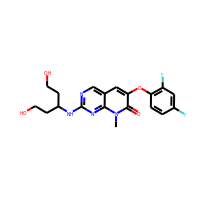
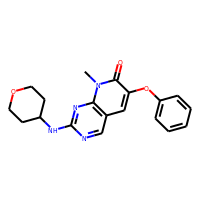
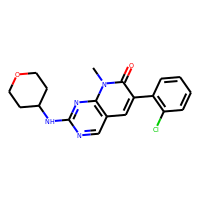
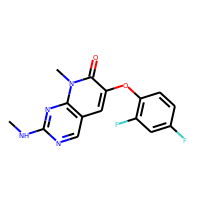
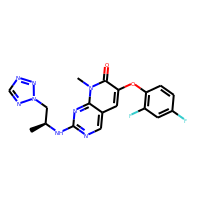
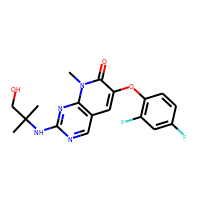
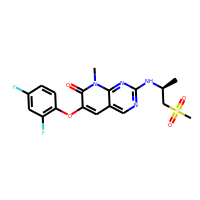
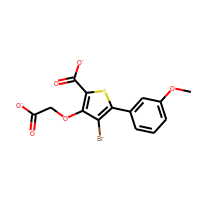
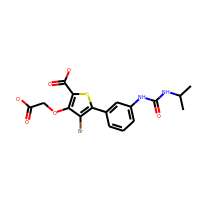
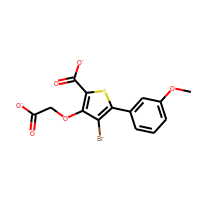
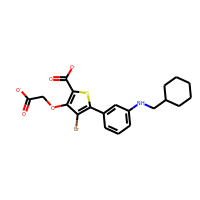
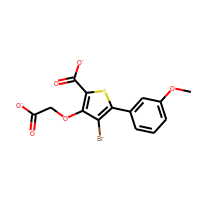
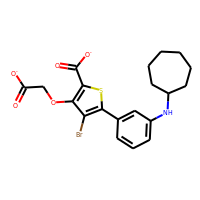
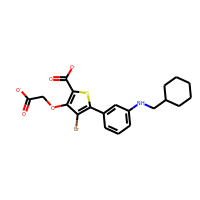
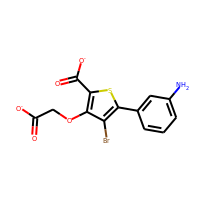
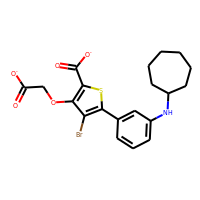
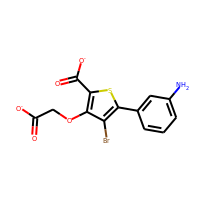
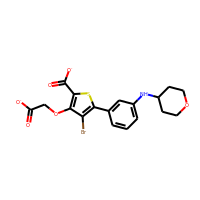
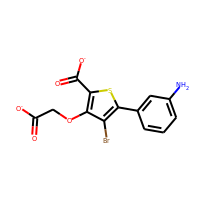
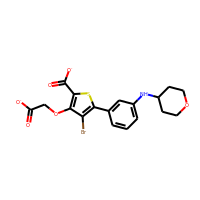
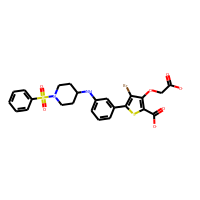
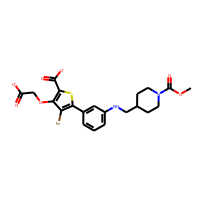
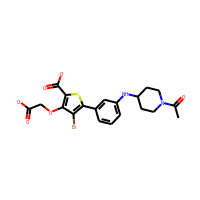
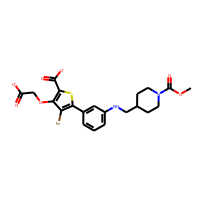
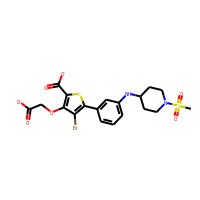
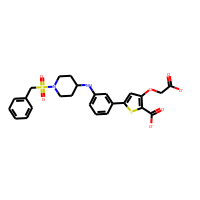
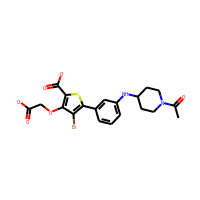
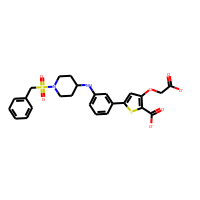
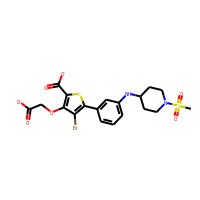
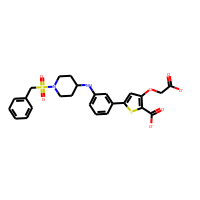
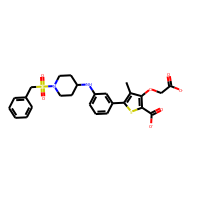
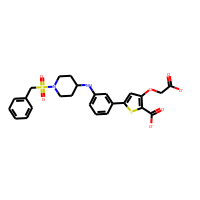
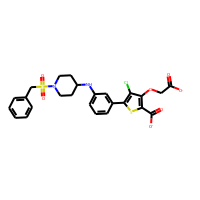
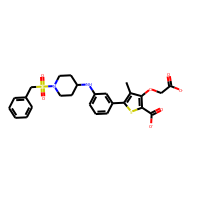
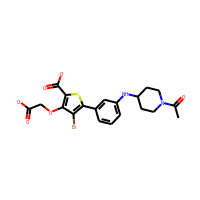
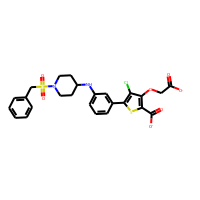
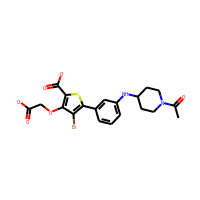
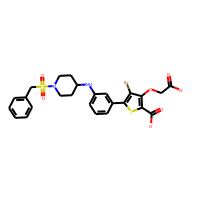
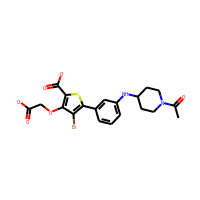
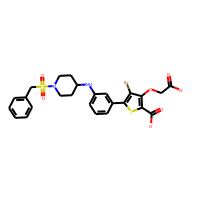
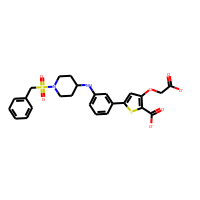
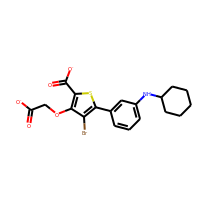
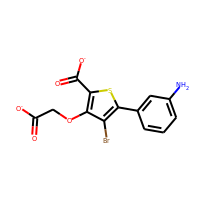
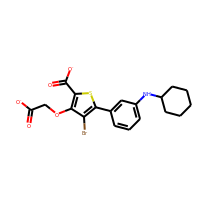
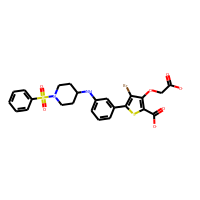
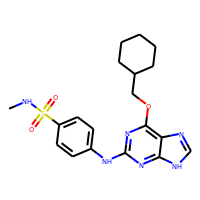
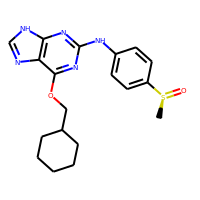
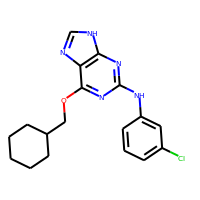
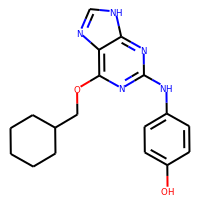
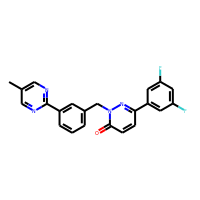
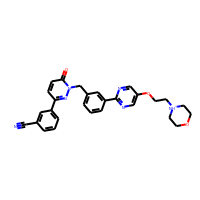
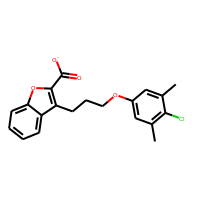
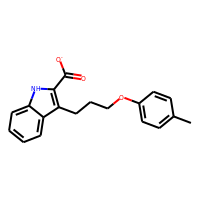
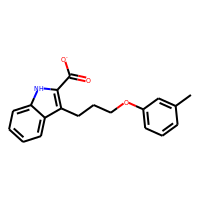
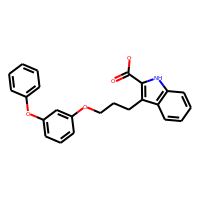
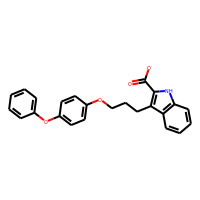
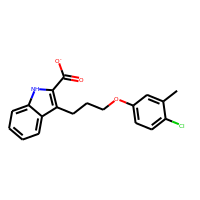
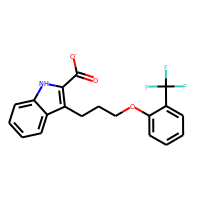
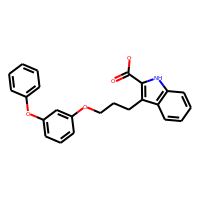
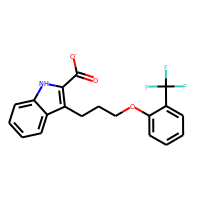
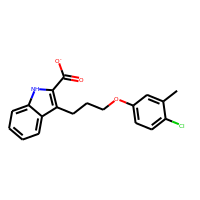
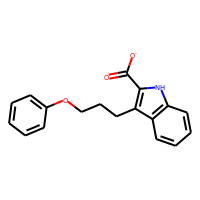
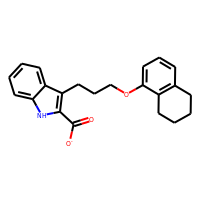
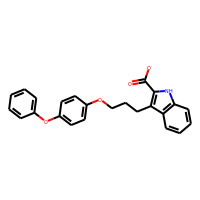
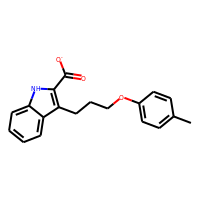
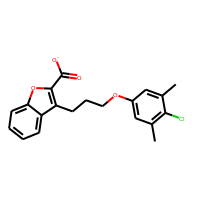
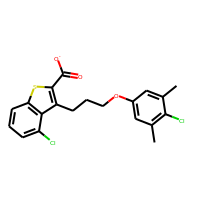
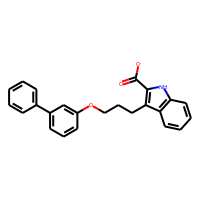
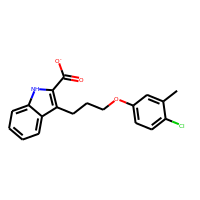
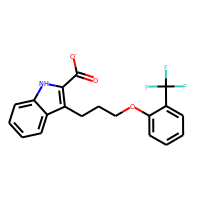
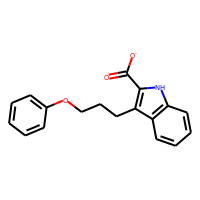
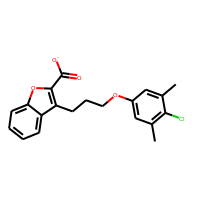
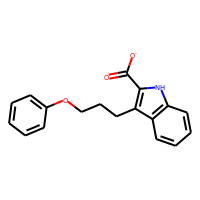
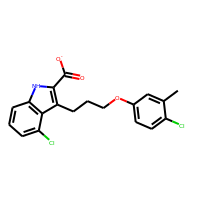
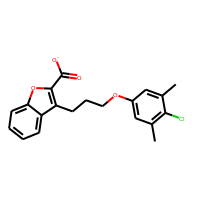
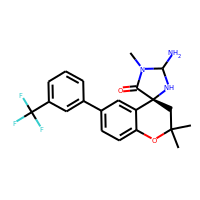
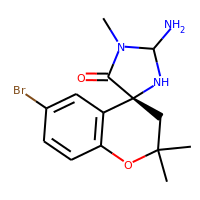
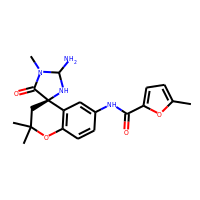
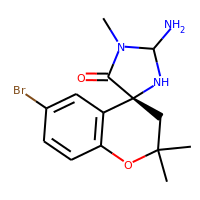
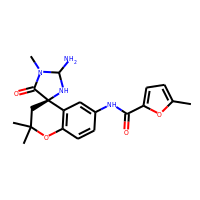
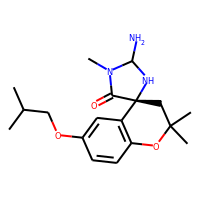

In [12]:
HTML(notConvEdges[['target',                    0,                        1,
                         'Mol1',                   'Mol2',
       'exp. DeltaG [kcal/mol]',  'exp. Error [kcal/mol]']].to_html())

# Correlation plots with experiment

In [13]:
def getRawResults(target, forcefield='openff-1.0.0.offxml'):
    # read in result file
    res = pd.read_csv(f'../results/{target}_{forcefield}.dat', header=None, comment='#', skipinitialspace=True, names=['calc DDG', 'calc dDDG' , 'add dDDG'], sep=' ')
    # read in exp. data
    edg = edges.edgeSet(target)
    df = edg.getDF(columns=[0,1, 'exp. DeltaG [kcal/mol]', 'exp. Error [kcal/mol]'])
    df.index = pd.Series(['edge_' + str(lig1) + '_' + str(lig2) for lig1, lig2 in zip(df[0].values, df[1].values)])
   
    # copy in calculated values
    df['calc_DDG'] = res.loc[:,'calc DDG']
    df['calc_dDDG'] = res.loc[:,'calc dDDG']
    df['calc_dDDG(additional)'] = res.loc[:, 'add dDDG']
    
    # remove unit of calculated values
    df['exp_DDG'] = df['exp. DeltaG [kcal/mol]'].apply(lambda x: x.magnitude)
    df['exp_dDDG'] = df['exp. Error [kcal/mol]'].apply(lambda x: x.magnitude)
    
    # add additional error line (so fare 0.0)
   # df['calc_dDDG(additional)'] = df['exp. Error [kcal/mol]'].apply(lambda x: 0.0)

    # filter only to relevant columns
    df = df.filter(items = [0,1,'exp_DDG', 'exp_dDDG', 'calc_DDG', 'calc_dDDG', 'calc_dDDG(additional)'])
    df[0]= df[0].astype(str)
    df[1]= df[1].astype(str)
    # create Results objects
    results = []
    for i, row in df.iterrows():
        results.append(wrangle.Result(*row.values))
    return df, results

In [14]:
forcefield = 'openff-1.0.0.offxml'
dfs = []
results = []
smiles = []
for target in targets.target_list:
    target = target["name"]
    if not os.path.exists(f'../results/{target}_{forcefield}.csv'):
        continue
    print(target)
    df, res = getRawResults(target, forcefield=forcefield)
    df['target'] = target
    dfs.append(df)
    results+=res
    
    lgs = ligands.ligandSet(target).getDF()
    lgs.index = lgs['name']
    for i, row in df.iterrows():
        smiles.append([lgs.loc[f'lig_{row[0]}', 'smiles'].values[0], lgs.loc[f'lig_{row[1]}', 'smiles'].values[0]])
resultsDF = pd.concat(dfs)
smiles[:10], results[:10]

jnk1
pde2
thrombin
p38
ptp1b
galectin
cdk2
cmet
mcl1
bace_hunt


([['CCOc1c(c(cc(n1)NC(=O)Cc2cc(c(cc2OC)Br)OC)N)C#N',
   'CCOc1c(c(cc(n1)NC(=O)Cc2cc(ccc2OC)OC)N)C#N'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cccc(c2)Cl)N)C#N',
   'CCOc1c(c(cc(n1)NC(=O)Cc2ccccc2)N)C#N'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cc(ccc2Br)Br)N)C#N',
   'CCOc1c(c(cc(n1)NC(=O)Cc2ccccc2Cl)N)C#N'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cccc(c2)OC)N)C#N',
   'CCOc1c(c(cc(n1)NC(=O)Cc2ccccc2)N)C#N'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cc(ccc2C)C)N)C#N',
   'CCOc1c(c(cc(n1)NC(=O)Cc2ccccc2Cl)N)C#N'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cccc(c2)Cl)N)C#N',
   'COc1ccc(c(c1)CC(=O)Nc2cc(c(c(n2)OCCO)C#N)N)OC'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cc(c(cc2OC)[N+](=O)[O-])OC)N)C#N',
   'COc1ccc(c(c1)CC(=O)Nc2cc(c(c(n2)OCCO)C#N)N)OC'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cccc(c2)Cl)N)C#N',
   'CCOc1c(c(cc(n1)NC(=O)Cc2ccccc2Cl)N)C#N'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2cc(c(cc2OC)S(=O)(=O)C)OC)N)C#N',
   'COc1ccc(c(c1)CC(=O)Nc2cc(c(c(n2)OCCO)C#N)N)OC'],
  ['CCOc1c(c(cc(n1)NC(=O)Cc2ccccc2C)N)C#N',
   'CCOc1c(c(cc(n1)NC(=O)Cc2ccccc2)N)C#N']],
  <freeenergyfr

In [15]:
plotting.plot_DDGs(results, smiles=smiles, method_name_y='pmx',target_name='all edges symmetrized',map_positive=False, symmetrise=True, filename=None, plotly=True)

### Filter out not converged edges.

In [16]:
filtered_results = [res for res, bC in zip(results, bConv) if bC]
filtered_smiles = [smi for smi, bC in zip(smiles, bConv) if bC]
plotting.plot_DDGs(filtered_results, smiles=filtered_smiles, method_name_y='pmx',target_name='all edges symmetrized',map_positive=False, symmetrise=True, filename=None, plotly=True)

In [17]:
resultsDF['AD'] = (resultsDF['exp_DDG'] - resultsDF['calc_DDG']).abs()

In [18]:
fig = go.Figure()
fig.add_trace(go.Violin(y=resultsDF['AD'], hovertext=resultsDF.index, name='all edges'))
fig.add_trace(go.Violin(y=resultsDF['AD'][bConv], hovertext=resultsDF.index[bConv], name='all edges filtered'))
fig.update_layout(
    title='Absolute Deviation (AD) between calculated and experimental results<br>filtered set excludes edges with convergence > 0.8',
    yaxis=dict(range=[0,10], title='AD(exp-calc) [kcal mol<sup>-1</sup>]'))

In [19]:
fig = go.Figure()

for target in targets.target_list:
    target = target["name"]
    if not os.path.exists(f'../results/{target}_{forcefield}.csv'):
        continue
    bTargetConv = [ bC if t else False for bC, t in zip(bConv, resultsDF['target']==target) ]
    fig.add_trace(go.Violin(y=resultsDF['AD'][resultsDF['target']==target], hovertext=resultsDF.index[resultsDF['target']==target], name=target))
    fig.add_trace(go.Violin(y=resultsDF['AD'][bTargetConv], hovertext=resultsDF.index[bTargetConv], name=f'{target} filtered'))
fig.update_layout(
    title='Absolute Deviation (AD) between calculated and experimental results<br>filtered set excludes edges with convergence > 0.8',
    yaxis=dict(range=[0,10], title='AD(exp-calc) [kcal mol<sup>-1</sup>]'))

# Filter out outliers of *converged* simulations with an Absolute Deviation > 2 kcal/mol

In [24]:
threshold = 2 #kcal / mol
bOutlier = resultsDF['AD'] > threshold
print(f'Number of outliers with AD > {threshold} kcal/mol: {bOutlier.sum()}')
bOutlier = [bO if bC else False for bO, bC in zip(bOutlier, bConv)]
print(f'Number of outliers with AD > {threshold} kcal/mol after removal of not converged outliers (=explainable outliers): {np.sum(bOutlier)}')
outlierEdges = resultsDF.index[bOutlier]
outlierTargets = resultsDF['target'][bOutlier]
dfs = []
for e, t in zip(outlierEdges, outlierTargets):
    eSet = edges.edgeSet(t)
    df = eSet[e].getDF()
    df['target'] = t
    dfs.append(df)
outlierEdges = pd.concat(dfs, axis=1).T
print('Number of outliers in different targets:\n', outlierTargets.value_counts())

Number of outliers with AD > 2 kcal/mol: 59
Number of outliers with AD > 2 kcal/mol after removal of not converged outliers (=explainable outliers): 42
Number of outliers in different targets:
 mcl1         10
cmet         10
bace_hunt     8
p38           5
pde2          3
jnk1          2
thrombin      2
ptp1b         1
cdk2          1
Name: target, dtype: int64



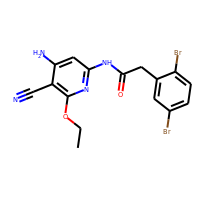
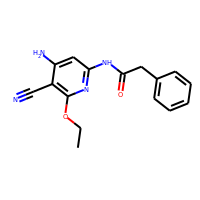
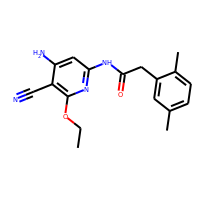
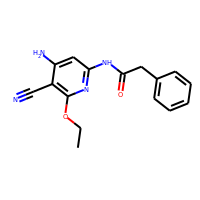
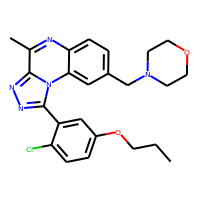
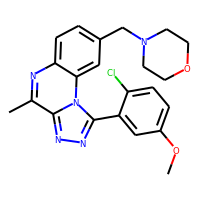
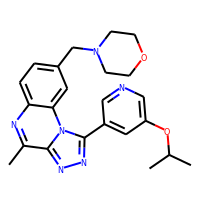
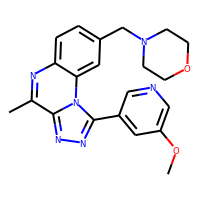
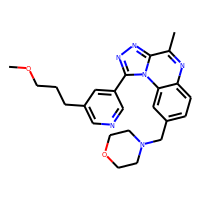
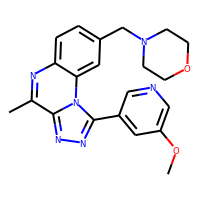
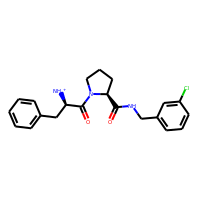
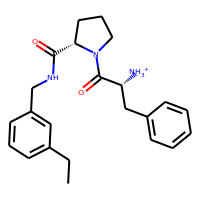
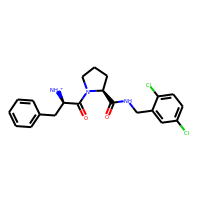
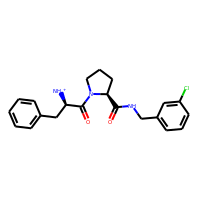
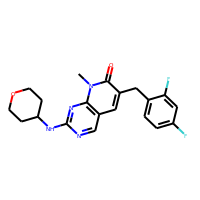
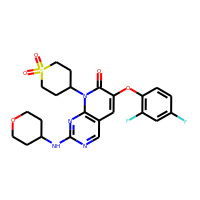
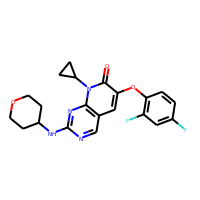
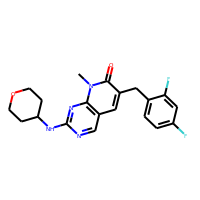
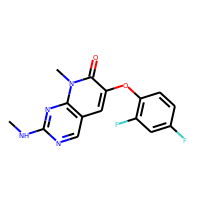
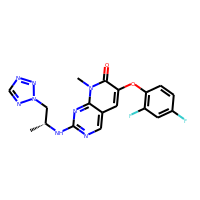
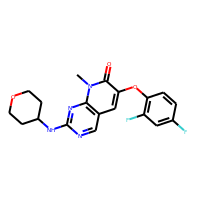
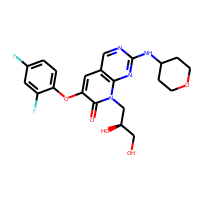
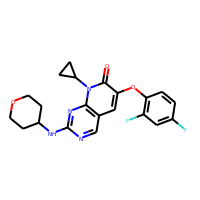
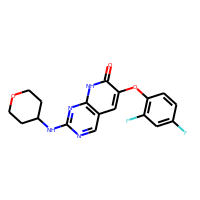
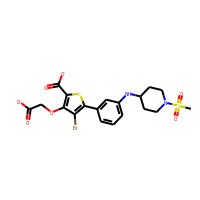
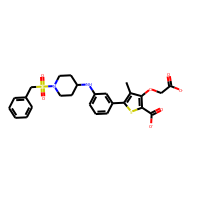
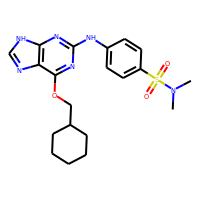
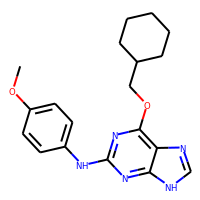
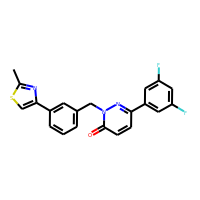
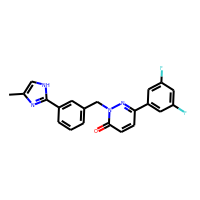
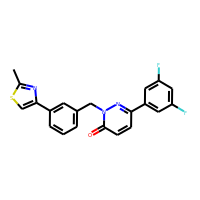
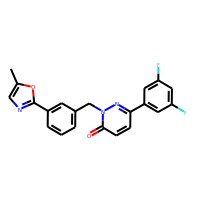
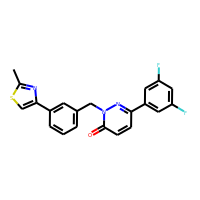
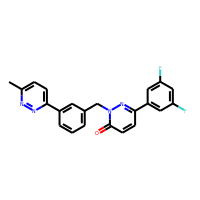
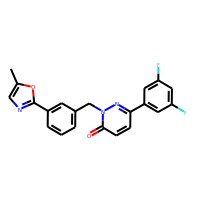
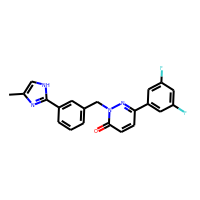
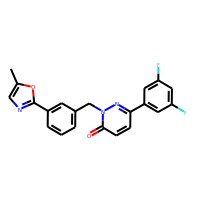
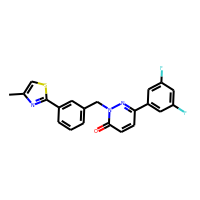
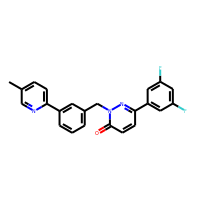
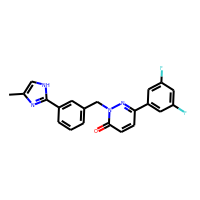
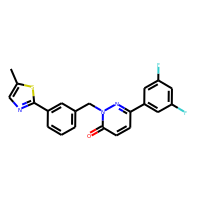
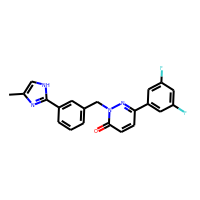
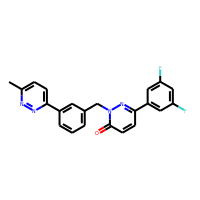
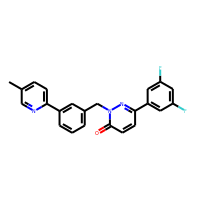
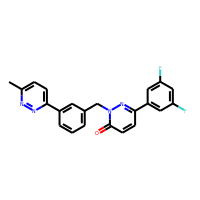
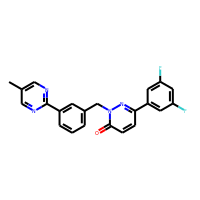
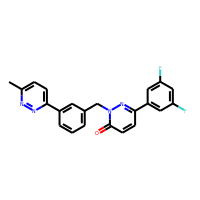
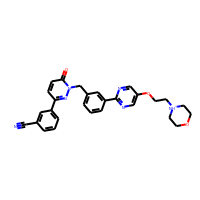
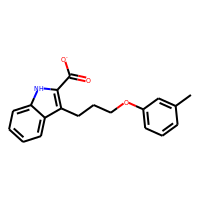
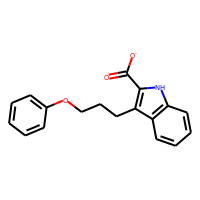
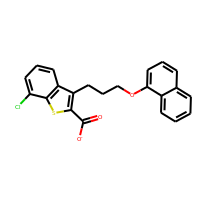
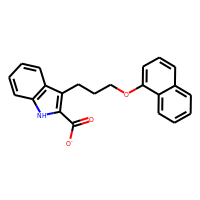
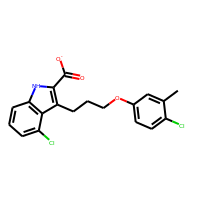
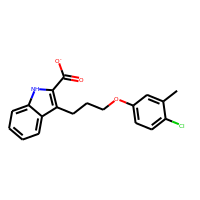
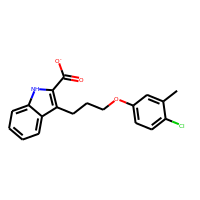
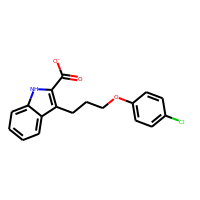
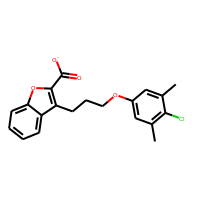
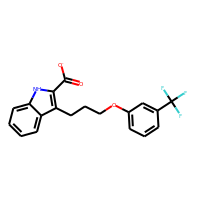
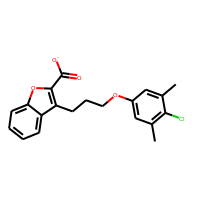
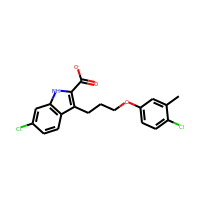
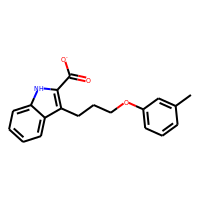
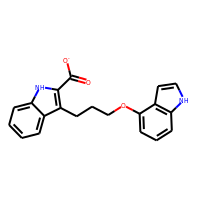
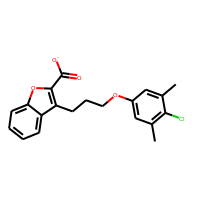
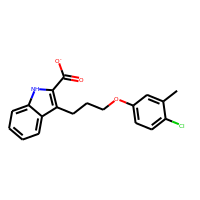
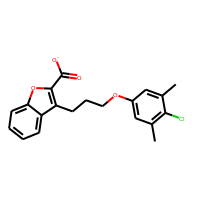
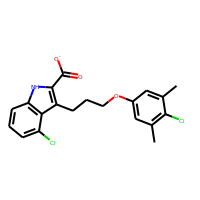
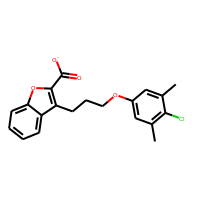
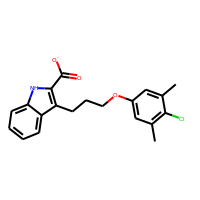
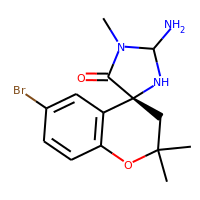
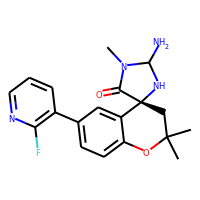
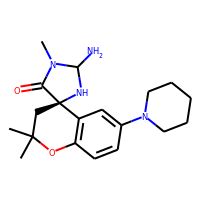
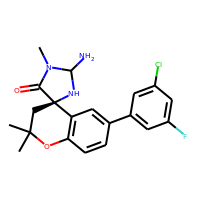
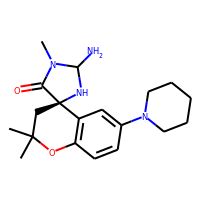
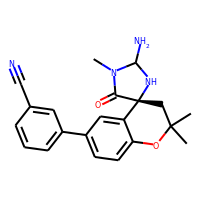
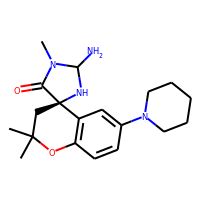
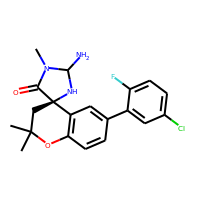
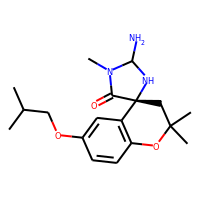
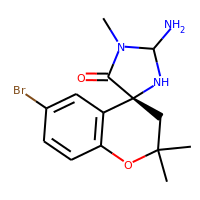
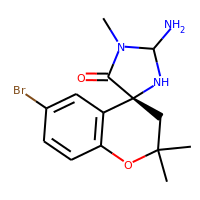
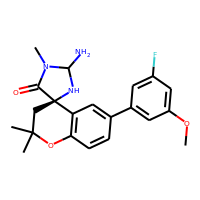
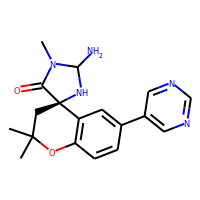
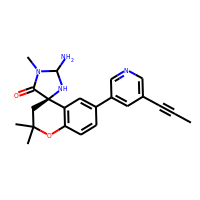
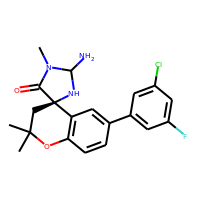
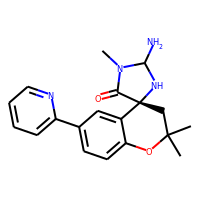

In [27]:
HTML(outlierEdges[['target',                    0,                        1,
                         'Mol1',                   'Mol2',
       'exp. DeltaG [kcal/mol]',  'exp. Error [kcal/mol]']].to_html())

In [28]:
f'The outliers occur solely in {outlierTargets.value_counts().shape[0]} out of {resultsDF["target"].value_counts().shape[0]} targets. This could hint to errors in the system preparation or special interaction types which are not well described by the force field.'

'The outliers occur solely in 9 out of 10 targets. This could hint to errors in the system preparation or special interaction types which are not well described by the force field.'